In [1]:
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydotplus
import scikitplot as skplt

from IPython.display import Image
from itertools import cycle
from mpl_toolkits.mplot3d import Axes3D
from scipy import interp
from scipy.stats import randint as sp_randint
from sklearn import metrics, tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix, classification_report, make_scorer, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import label_binarize, MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import export_graphviz
from sklearn.utils import resample

# Classification (with statistically assigned labels)

In [2]:
customer_profile = pd.read_csv('datasets/customer_indicators.csv', index_col=0)

In [3]:
ranges_m = [0.3, 0.7]
quantiles_m = customer_profile.quantile(q=ranges_m)
quantiles_m['RMonetary']

0.3      7.145611
0.7    127.860000
Name: RMonetary, dtype: float64

In [4]:
ranges_d = [0.3, 0.7]
quantiles_d = customer_profile.quantile(q=ranges_d)
quantiles_d['Delta']

0.3      1.0
0.7    224.0
Name: Delta, dtype: float64

In [5]:
ranges_r = [0.3, 0.8]
quantiles_r = customer_profile.quantile(q=ranges_r)
quantiles_r['Recency']

0.3     22.0
0.8    179.0
Name: Recency, dtype: float64

In [6]:
def ScoreM(x, data, thresh):
    if x <= thresh[data][ranges_m[0]]:
        return 1
    elif x <= thresh[data][ranges_m[1]]:
        return 2
    else:
        return 3

def ScoreD(x, data, thresh):
    if x <= thresh[data][ranges_d[0]]:
        return 1
    elif x <= thresh[data][ranges_d[1]]:
        return 2
    else:
        return 3

def ScoreR(x, data, thresh):
    if x <= thresh[data][ranges_r[0]]:
        return 3
    elif x <= thresh[data][ranges_r[1]]:
        return 2
    else:
        return 1

In [7]:
customer_profile['MScore'] = customer_profile['RMonetary'].apply(ScoreM, args=('RMonetary', quantiles_m))
customer_profile['DScore'] = customer_profile['Delta'].apply(ScoreD, args=('Delta', quantiles_d))
customer_profile['RScore'] = customer_profile['Recency'].apply(ScoreR, args=('Recency', quantiles_r))
customer_profile['Score'] = (0.3 * customer_profile['MScore']
                           + 0.4 * customer_profile['DScore']
                           + 0.3 * customer_profile['RScore'])
#customer_profile.describe()

In [8]:
ranges = [0.2, 0.7]
quantiles = customer_profile.quantile(q=ranges)

In [9]:
def Score(x, data, thresh):
    if x <= thresh[data][ranges[0]]:
        return 'Low'
    elif x <= thresh[data][ranges[1]]:
        return 'Medium'
    else:
        return 'High'

In [10]:
customer_labeled = customer_profile.copy()
customer_labeled['Label'] = customer_labeled['Score'].apply(Score, args=('Score', quantiles))
customer_labeled.head()

df_majority = customer_labeled[customer_labeled.Label == 'Medium']
df_minority = customer_labeled[customer_labeled.Label == 'High']
df_middle   = customer_labeled[customer_labeled.Label == 'Low']

customer_labeled.Label.value_counts()

Medium    2110
High      1231
Low        981
Name: Label, dtype: int64

In [11]:
'''customer_labeled['Delta'] = customer_labeled[['Delta']].apply(np.log10, axis=1).round(3)
customer_labeled['RMonetary'] = customer_labeled[['RMonetary']].apply(np.log10, axis=1).round(3)'''

"customer_labeled['Delta'] = customer_labeled[['Delta']].apply(np.log10, axis=1).round(3)\ncustomer_labeled['RMonetary'] = customer_labeled[['RMonetary']].apply(np.log10, axis=1).round(3)"

In [12]:
'''fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(customer_labeled['Delta'], customer_labeled['Recency'], customer_labeled['RMonetary'],
           c=customer_labeled['Label_num'])
ax.set_xlabel('Delta')
ax.set_ylabel('Recency')
ax.set_zlabel('Relative Monetary')
plt.show()'''

"fig = plt.figure()\nax = Axes3D(fig)\nax.scatter(customer_labeled['Delta'], customer_labeled['Recency'], customer_labeled['RMonetary'],\n           c=customer_labeled['Label_num'])\nax.set_xlabel('Delta')\nax.set_ylabel('Recency')\nax.set_zlabel('Relative Monetary')\nplt.show()"

In [13]:
# Upsample minority classes

df_minority_upsampled = resample(df_minority,
                                 replace=True, # sample with replacement
                                 n_samples=len(df_majority))

df_middle_upsampled = resample(df_middle,
                               replace=True,
                               n_samples=len(df_majority))

# Combine majority class with upsampled minority classes
df_upsampled = pd.concat([df_majority, df_minority_upsampled, df_middle_upsampled])
 
# Display new class counts
customer_labeled = df_upsampled
df_upsampled.Label.value_counts()

Medium    2110
Low       2110
High      2110
Name: Label, dtype: int64

In [14]:
# Function to discretize the variables
# Input: the dataset and the list of variables' names to discretize

def discretize_data(dataset, variables):
    for variable in variables:
        mapping = {'High': 0, 'Medium': 1, 'Low': 2}

        # Add a new colum with the number representation of the variable
        dataset[variable + '_num'] = dataset[variable].map(mapping).astype(int)
    return dataset

In [15]:
variables = ['Label']

# Discretize data, in this case only Label
customer_labeled = discretize_data(customer_labeled, variables)

# Drop the categorical variables since we don't need them anymore
customer_labeled = customer_labeled[['Recency', 'RFrequency', 'Max_items', 'Label_num']]

label = customer_labeled.pop('Label_num')

scaler = MinMaxScaler()
customer_labeled = scaler.fit_transform(customer_labeled.values)

train_set, test_set, train_label, test_label = train_test_split(
                                                 customer_labeled, label, stratify=label, test_size=0.3)

In [16]:
train_label.head()

2703    2
3488    0
2894    1
302     0
641     2
Name: Label_num, dtype: int64

## Expected prediction

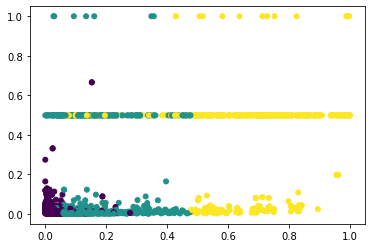

In [17]:
# x: Recency
# y: Frequency
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_label.values, s=25)

## Decision Tree

In [18]:
# Decision tree

param_dist = {"max_depth": [2,3,5,6,7,10,12,None],
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "criterion": ["entropy", "gini"],
              "splitter": ["best", "random"]
              }

n_iter_search = 50

dec_t = tree.DecisionTreeClassifier()
grid_search = RandomizedSearchCV(dec_t, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

In [19]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'criterion': 'entropy', 'max_depth': 2, 'min_samples_leaf': 27, 'min_samples_split': 34, 'splitter': 'random'}
Mean and std of this setting  0.7280421233722112 0.03155498494084637


In [20]:
# Decision tree

dec_t = tree.DecisionTreeClassifier(criterion='gini',
                                    splitter='best',
                                    max_depth=5,
                                    min_samples_split=23,
                                    min_samples_leaf=48).fit(train_set, train_label)

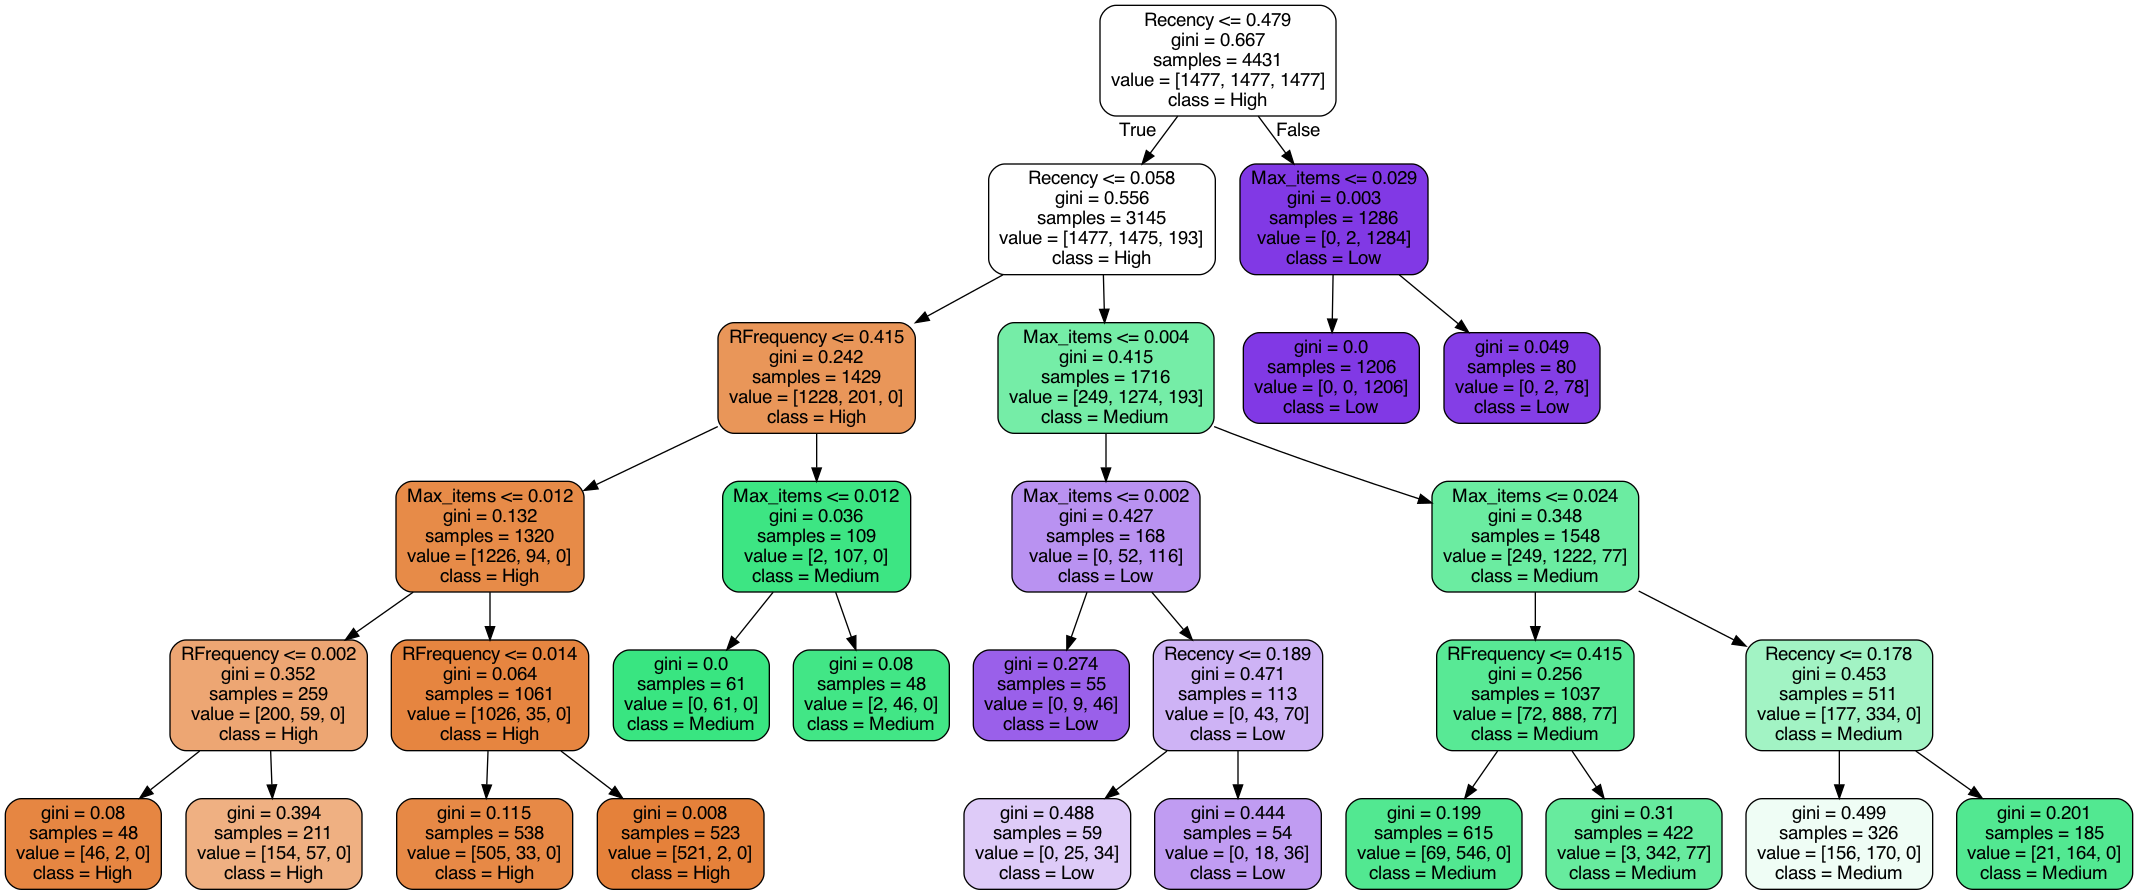

In [21]:
# Show decision tree

dot_data = tree.export_graphviz(dec_t, out_file=None,
                                feature_names=['Recency', 'RFrequency', 'Max_items'],
                                class_names=['High', 'Medium', 'Low'],
                                filled=True,
                                rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [22]:
def predict(model, train_set, test_set):
    train_pred = model.predict(train_set)
    test_pred = model.predict(test_set)
    return train_pred, test_pred

In [23]:
train_pred_dt, test_pred_dt = predict(dec_t, train_set, test_set)

### Evaluation of the decision tree: compute accuracy, precision, recall, confusion matrix

In [24]:
def print_scores(train_label, train_pred, test_label, test_pred, target_names_):
    print('Accuracy train set:', metrics.accuracy_score(train_label, train_pred))
    print('Accuracy test set: ', metrics.accuracy_score(test_label, test_pred))
    print()
    print('F1 score train set:', metrics.f1_score(train_label, train_pred, average='weighted'))
    print('F1 score test set: ', metrics.f1_score(test_label, test_pred, average='weighted'))
    print('Train:')
    print(classification_report(train_label, train_pred, target_names=target_names_))
    print('-' * 53)
    print('Test:')
    print(classification_report(test_label, test_pred, target_names=target_names_))

In [25]:
print_scores(train_label, train_pred_dt, test_label, test_pred_dt, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8925750394944708
Accuracy test set:  0.9025803054239073

F1 score train set: 0.8933587785805532
F1 score test set:  0.9032127787836617
Train:
              precision    recall  f1-score   support

        High       0.93      0.83      0.88      1477
      Medium       0.80      0.90      0.85      1477
         Low       0.96      0.95      0.96      1477

    accuracy                           0.89      4431
   macro avg       0.90      0.89      0.89      4431
weighted avg       0.90      0.89      0.89      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.94      0.85      0.89       633
      Medium       0.82      0.91      0.86       633
         Low       0.96      0.95      0.96       633

    accuracy                           0.90      1899
   macro avg       0.91      0.90      0.90      1899
weighted avg       0.91      0.90      0.90      1899



In [26]:
# compute confusion matrix

print('Train:')
print(confusion_matrix(train_label, train_pred_dt))
print('-' * 18)
print('Test:')
print(confusion_matrix(test_label, test_pred_dt))

Train:
[[1226  251    0]
 [  94 1329   54]
 [   0   77 1400]]
------------------
Test:
[[538  95   0]
 [ 37 573  23]
 [  0  30 603]]


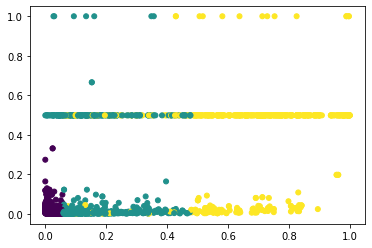

In [27]:
# x: Recency
# y: Frequency
plt.scatter(test_set[:, 0], test_set[:, 1], c=test_pred_dt, s=25)

## SVM

In [28]:
# Binarize the output
test_label_binarized = label_binarize(test_label, classes=[0, 1, 2])
train_label_binarized = label_binarize(train_label, classes=[0, 1, 2])

svm = SVC(kernel='rbf', C=0.75, gamma='scale').fit(train_set, train_label)
svm_binarize = OneVsRestClassifier(svm).fit(train_set, train_label_binarized)

In [29]:
# Predictions

train_pred_svm_binarized, test_pred_svm_binarized = predict(svm_binarize, train_set, test_set)
train_pred_svm, test_pred_svm = predict(svm, train_set, test_set)

In [30]:
# Compute the performance of the model

print_scores(train_label, train_pred_svm, test_label, test_pred_svm, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8584969532836831
Accuracy test set:  0.8604528699315429

F1 score train set: 0.8585557509240811
F1 score test set:  0.8608699458332006
Train:
              precision    recall  f1-score   support

        High       0.82      0.92      0.87      1477
      Medium       0.80      0.77      0.78      1477
         Low       0.96      0.89      0.92      1477

    accuracy                           0.86      4431
   macro avg       0.86      0.86      0.86      4431
weighted avg       0.86      0.86      0.86      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.83      0.93      0.88       633
      Medium       0.79      0.79      0.79       633
         Low       0.97      0.87      0.91       633

    accuracy                           0.86      1899
   macro avg       0.86      0.86      0.86      1899
weighted avg       0.86      0.86      0.86      1899



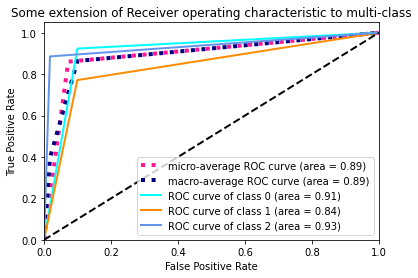

In [31]:
n_classes = 3
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(train_label_binarized[:, i], train_pred_svm_binarized[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(train_label_binarized.ravel(), train_pred_svm_binarized.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

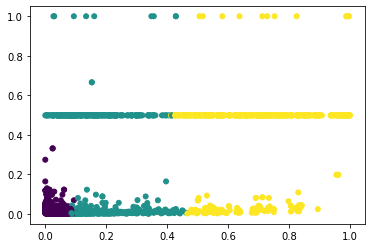

In [32]:
# x: Frequency
# y: Max items
plt.scatter(test_set[:, 0], test_set[:, 1], c= test_pred_svm, s=25)

## KNN

In [33]:
knn = KNeighborsClassifier(n_neighbors=8, metric='minkowski').fit(train_set, train_label)

In [34]:
train_pred_knn, test_pred_knn = predict(knn, train_set, test_set)

In [35]:
print_scores(train_label, train_pred_knn, test_label, test_pred_knn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.9187542315504401
Accuracy test set:  0.9025803054239073

F1 score train set: 0.9185285157740262
F1 score test set:  0.9023033490150827
Train:
              precision    recall  f1-score   support

        High       0.88      0.96      0.92      1477
      Medium       0.90      0.85      0.87      1477
         Low       0.98      0.95      0.97      1477

    accuracy                           0.92      4431
   macro avg       0.92      0.92      0.92      4431
weighted avg       0.92      0.92      0.92      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.86      0.96      0.90       633
      Medium       0.88      0.82      0.85       633
         Low       0.98      0.93      0.95       633

    accuracy                           0.90      1899
   macro avg       0.90      0.90      0.90      1899
weighted avg       0.90      0.90      0.90      1899



## Classification with Random Forest

In [36]:
# To find the best set of parameter setting, we can run a grid search.

param_dist = {"max_depth": [2, 3, 5, 6, 7, 10, 12, None],
              "max_features": sp_randint(1,len(train_set[0]) + 1),
              "min_samples_split": sp_randint(10, 51),
              "min_samples_leaf": sp_randint(10, 51),
              "bootstrap": [True, False],
              "criterion": ["entropy", "gini"],
              "class_weight": ['balanced', None, {0: 0.25, 1: 0.50, 2:0.25}]}

n_iter_search = 50

clf = RandomForestClassifier(n_estimators=30)

grid_search = RandomizedSearchCV(clf, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score)).fit(train_set, train_label)

In [37]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])
print('Mean and std of this setting ', grid_search.cv_results_['mean_test_score'][0], 
      grid_search.cv_results_['std_test_score'][0])

Best setting parameters  {'bootstrap': False, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 2, 'min_samples_leaf': 47, 'min_samples_split': 26}
Mean and std of this setting  0.9036331154040937 0.007876006921968812


In [38]:
rf = RandomForestClassifier(n_estimators=30, 
                             criterion='gini',
                             max_features=2,
                             class_weight= 'balanced',
                             max_depth=2, 
                             min_samples_split=12,
                             min_samples_leaf=41,
                             bootstrap=False).fit(train_set, train_label)

In [39]:
train_pred_rf, test_pred_rf = predict(rf, train_set, test_set)

In [40]:
print_scores(train_label, train_pred_rf, test_label, test_pred_rf, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8781313473256601
Accuracy test set:  0.8778304370721433

F1 score train set: 0.8808469485921822
F1 score test set:  0.8806538487335371
Train:
              precision    recall  f1-score   support

        High       0.93      0.83      0.88      1477
      Medium       0.76      0.94      0.84      1477
         Low       1.00      0.87      0.93      1477

    accuracy                           0.88      4431
   macro avg       0.89      0.88      0.88      4431
weighted avg       0.89      0.88      0.88      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.94      0.85      0.89       633
      Medium       0.75      0.94      0.84       633
         Low       1.00      0.84      0.91       633

    accuracy                           0.88      1899
   macro avg       0.90      0.88      0.88      1899
weighted avg       0.90      0.88      0.88      1899



## Neural networks

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(1, len(customer_labeled[0]))))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [42]:
train_label_nn = to_categorical(train_label, 3)
test_label_nn = to_categorical(test_label, 3)

In [43]:
history = model.fit(train_set, train_label_nn,
                    epochs=40,
                    batch_size=256,
                    validation_split=0.3)

Epoch 1/40
13/13 [==============================] - 0s 24ms/step - loss: 1.0819 - accuracy: 0.4953 - val_loss: 1.0608 - val_accuracy: 0.7361
Epoch 2/40
13/13 [==============================] - 0s 4ms/step - loss: 1.0463 - accuracy: 0.6936 - val_loss: 1.0113 - val_accuracy: 0.7226
Epoch 3/40
13/13 [==============================] - 0s 5ms/step - loss: 0.9916 - accuracy: 0.6869 - val_loss: 0.9332 - val_accuracy: 0.7218
Epoch 4/40
13/13 [==============================] - 0s 5ms/step - loss: 0.9100 - accuracy: 0.7024 - val_loss: 0.8235 - val_accuracy: 0.7376
Epoch 5/40
13/13 [==============================] - 0s 5ms/step - loss: 0.8127 - accuracy: 0.7217 - val_loss: 0.7050 - val_accuracy: 0.7684
Epoch 6/40
13/13 [==============================] - 0s 5ms/step - loss: 0.7152 - accuracy: 0.7404 - val_loss: 0.5991 - val_accuracy: 0.7842
Epoch 7/40
13/13 [==============================] - 0s 4ms/step - loss: 0.6277 - accuracy: 0.7588 - val_loss: 0.5161 - val_accuracy: 0.8045
Epoch 8/40
13/13 [=

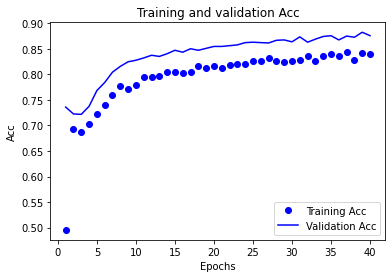

In [44]:
lw = 2
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training Acc')
plt.plot(epochs, val_acc, 'b', label='Validation Acc')
plt.title('Training and validation Acc')
plt.xlabel('Epochs')
plt.ylabel('Acc')
plt.legend()
plt.show()

In [45]:
train_pred_nn = np.argmax(model.predict(train_set), axis=-1)
test_pred_nn = np.argmax(model.predict(test_set), axis=-1)

In [46]:
print_scores(train_label, train_pred_nn, test_label, test_pred_nn, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8621078763258858
Accuracy test set:  0.865192206424434

F1 score train set: 0.8628297218620231
F1 score test set:  0.8660816446582101
Train:
              precision    recall  f1-score   support

        High       0.86      0.89      0.88      1477
      Medium       0.79      0.81      0.80      1477
         Low       0.95      0.89      0.92      1477

    accuracy                           0.86      4431
   macro avg       0.86      0.86      0.86      4431
weighted avg       0.86      0.86      0.86      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.87      0.91      0.89       633
      Medium       0.79      0.82      0.80       633
         Low       0.95      0.87      0.91       633

    accuracy                           0.87      1899
   macro avg       0.87      0.87      0.87      1899
weighted avg       0.87      0.87      0.87      1899



## Classification with Naive Bayes

In [47]:
gnb = GaussianNB().fit(train_set, train_label)

train_pred_gnb, test_pred_gnb = predict(gnb, train_set, test_set)

In [48]:
print_scores(train_label, train_pred_gnb, test_label, test_pred_gnb, ['High', 'Medium', 'Low'])

Accuracy train set: 0.8201308959602799
Accuracy test set:  0.8256977356503423

F1 score train set: 0.8150137839187138
F1 score test set:  0.8221694778393667
Train:
              precision    recall  f1-score   support

        High       0.76      0.94      0.84      1477
      Medium       0.80      0.62      0.70      1477
         Low       0.91      0.90      0.91      1477

    accuracy                           0.82      4431
   macro avg       0.82      0.82      0.82      4431
weighted avg       0.82      0.82      0.82      4431

-----------------------------------------------------
Test:
              precision    recall  f1-score   support

        High       0.76      0.95      0.85       633
      Medium       0.80      0.65      0.71       633
         Low       0.94      0.88      0.91       633

    accuracy                           0.83      1899
   macro avg       0.83      0.83      0.82      1899
weighted avg       0.83      0.83      0.82      1899



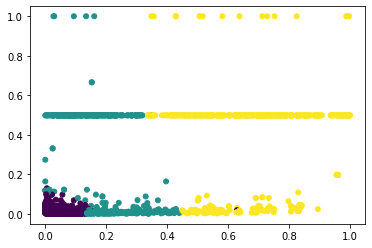

In [49]:
# x: Recency
# y: Frequency
plt.scatter(test_set[:, 0], test_set[:, 1], c= test_pred_gnb, s=25)